In [34]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [35]:
class USBType(Enum):
    USB_A = "USB-A"
    USB_C = "USB-C"
    MICRO_USB = "Micro-USB"
    MINI_USB = "Mini-USB"
    USB_B = "USB-B"
    UNKNOWN = "Unknown"

In [36]:
image_path = 'test1.jpg'

In [37]:
# Parameters for feature extraction and classification
debug_mode = True  # Set to True to display intermediate steps

In [38]:
def display_steps(stage_name, images):

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(stage_name)

    for i, (title, img) in enumerate(images):
        if len(images) == 1:
            ax = axes
        else:
            ax = axes[i]

        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:  # Color
            ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [39]:
def preprocess_image(image_path):

    original = cv.imread(image_path)
    if original is None:
        raise Exception(f"Could not load image: {image_path}")

    result_img = original.copy()

    gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv.GaussianBlur(enhanced, (5, 5), 0)
    median_blurred = cv.medianBlur(blurred, 5)

    _, binary_otsu = cv.threshold(median_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    binary_adaptive = cv.adaptiveThreshold(median_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv.THRESH_BINARY, 11, 2)

    binary = cv.bitwise_and(binary_otsu, binary_adaptive)

    white_pixel_ratio = np.sum(binary == 255) / binary.size
    if white_pixel_ratio > 0.5:
        binary = cv.bitwise_not(binary)

    if debug_mode: #! function call
        display_steps("Preprocessing", [ #! function call
            ("Original", original),
            ("Grayscale", gray),
            ("Enhanced", enhanced),
            ("Blurred", blurred),
            ("Binary (Otsu)", binary_otsu),
            ("Binary (Adaptive)", binary_adaptive),
            ("Binary (Combined)", binary)
        ])

    return original, gray, binary

In [40]:
def extract_features(gray_img, binary_img):

    # Apply Canny edge detection with adjusted thresholds
    edges = cv.Canny(gray_img, 30, 150)

    # Morphological operations to clean up the binary image
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv.morphologyEx(binary_img, cv.MORPH_CLOSE, kernel)
    morphed = cv.morphologyEx(morphed, cv.MORPH_OPEN, kernel)

    # Try different contour retrieval methods
    contours_ext, _ = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours_all, _ = cv.findContours(morphed, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    # Also try using edge image for contour detection
    contours_edges, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Combine all detected contours
    all_contours = contours_ext + contours_all + contours_edges

    if not all_contours:
        raise Exception("No contours found. Check the preprocessing steps.")

    # Filter contours by minimum area to avoid detecting noise
    min_area = 500  # Lower threshold to detect small USBs
    valid_contours = [cnt for cnt in all_contours if cv.contourArea(cnt) > min_area]

    if not valid_contours:
        raise Exception("No valid contours found after filtering. Check the preprocessing steps.")

    usb_contour = max(valid_contours, key=cv.contourArea)

    # Create a mask for the USB
    mask = np.zeros_like(gray_img)
    cv.drawContours(mask, [usb_contour], -1, 255, thickness=cv.FILLED)

    # Extract the USB region
    usb_region = cv.bitwise_and(gray_img, gray_img, mask=mask)

    # Get rotated rectangle for orientation correction
    rect = cv.minAreaRect(usb_contour)
    box = cv.boxPoints(rect)
    box = np.int32(box)

    # Calculate aspect ratio (important feature for classification)
    width, height = rect[1]
    aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 0

    # Extract additional geometric features
    area = cv.contourArea(usb_contour)
    perimeter = cv.arcLength(usb_contour, True)
    compactness = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    # Special feature: Detect internal structures (pins) for USB-A
    # Apply more aggressive edge detection just on the USB region
    usb_edges = cv.Canny(usb_region, 20, 80)  # Lower thresholds for better pin detection
    internal_contours, _ = cv.findContours(usb_edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    # Count internal contours that could be pins
    pin_candidates = []
    for cnt in internal_contours:
        # Adjust area thresholds for pin detection
        if cv.contourArea(cnt) > 5 and cv.contourArea(cnt) < area * 0.2:  # More inclusive
            pin_candidates.append(cnt)

    # Detect horizontal lines (USB-A pins are typically horizontal)
    horizontal_lines = 0
    if len(pin_candidates) > 0:
        for cnt in pin_candidates:
            x, y, w, h = cv.boundingRect(cnt)
            # Check if width significantly greater than height (horizontal orientation)
            # Relaxed criteria slightly
            if w > 1.5*h and w > 8:
                horizontal_lines += 1

    # Detect central line/slot feature for USB-C
    central_line_detected = False
    central_line_length = 0

    # Create a copy of the USB region for line detection
    line_detection_img = usb_region.copy()

    # Apply more aggressive edge detection for central line
    central_lines_edges = cv.Canny(line_detection_img, 50, 150)

    # Use HoughLinesP to detect lines
    lines = cv.HoughLinesP(central_lines_edges, 1, np.pi/180,
                            threshold=30, minLineLength=20, maxLineGap=10)

    # Check if any horizontal lines are detected in the center
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            # Check if line is mostly horizontal
            if abs(y2 - y1) < 0.2 * abs(x2 - x1):
                # Check if line is in the center region
                center_y = mask.shape[0] // 2
                if abs((y1 + y2) / 2 - center_y) < mask.shape[0] * 0.3:
                    central_line_detected = True
                    central_line_length = max(central_line_length, line_length)

    # Detect Harris corners
    corner_img = gray_img.copy()
    corner_img = np.float32(corner_img)
    harris_corners = cv.cornerHarris(corner_img, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv.dilate(harris_corners, None)

    # Count significant corners in the USB region only
    corner_threshold = 0.01 * harris_corners.max()
    masked_corners = cv.bitwise_and(harris_corners, harris_corners, mask=mask)
    corner_count = np.sum(masked_corners > corner_threshold)

    # Convexity defects analysis for pin detection
    hull = cv.convexHull(usb_contour, returnPoints=False)
    defects = None
    pin_count = 0

    try:
        if len(hull) > 3:  # Need at least 4 points for convexity defects
            defects = cv.convexityDefects(usb_contour, hull)
            if defects is not None:
                # Filter significant defects (potential pins)
                significant_defects = [defect for defect in defects if defect[0][3] > 1000]
                pin_count = len(significant_defects)
    except:
        pass

    # Analyze for rectangular shape (USB-A characteristic)
    # Calculate how rectangular the shape is by comparing area to bbox area
    x, y, w, h = cv.boundingRect(usb_contour)
    bbox_area = w * h
    rectangularity = area / bbox_area if bbox_area > 0 else 0

    # Symmetry analysis - improved for better USB-C detection
    # Vertical symmetry (important for USB-C)
    rows, cols = mask.shape

    # Get the vertical central axis
    center_col = cols // 2

    # Compare left and right halves
    left_half = mask[:, :center_col]
    right_half = mask[:, center_col:]
    right_half_flipped = cv.flip(right_half, 1)  # Flip horizontally

    # Crop to same size if needed
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    left_half_cropped = left_half[:, -min_width:]
    right_half_flipped_cropped = right_half_flipped[:, :min_width]

    # Calculate symmetry score (lower is more symmetric)
    if left_half_cropped.size > 0 and right_half_flipped_cropped.size > 0:
        diff = cv.bitwise_xor(left_half_cropped, right_half_flipped_cropped)
        # With this (normalize to 0-1):
        symmetry_score = np.sum(diff) / (255.0 * min_width * rows) if (min_width * rows) > 0 else 1.0  # 255 for uint8 image
    else:
        symmetry_score = 1.0

    # Calculate roundedness at the ends (important for USB-C)
    # Use the contour to find the end curvature
    end_roundedness = 0.0
    try:
        # Fit ellipse to get roundedness information
        ellipse = cv.fitEllipse(usb_contour)
        major_axis, minor_axis = ellipse[1]
        # Roundedness is the ratio of minor to major (closer to 1 means more circular)
        if major_axis > 0:
            end_roundedness = min(minor_axis / major_axis, 1.0) if major_axis > 0 else 0.0
    except:
        pass

    # Create a feature dictionary
    features = {
        'contour': usb_contour,
        'box': box,
        'aspect_ratio': aspect_ratio,
        'area': area,
        'perimeter': perimeter,
        'compactness': compactness,
        'corner_count': corner_count,
        'pin_count': pin_count,
        'horizontal_lines': horizontal_lines,
        'symmetry_score': symmetry_score,
        'rectangularity': rectangularity,
        'mask': mask,
        'usb_region': usb_region,
        'usb_edges': usb_edges,
        'central_line_detected': central_line_detected,
        'central_line_length': central_line_length,
        'end_roundedness': end_roundedness
    }

    # Print feature values for debugging
    print(f"Extracted Features:")
    print(f"  - Aspect Ratio: {aspect_ratio:.2f}")
    print(f"  - Area: {area}")
    print(f"  - Perimeter: {perimeter:.2f}")
    print(f"  - Compactness: {compactness:.2f}")
    print(f"  - Corner Count: {corner_count}")
    print(f"  - Pin Count: {pin_count}")
    print(f"  - Horizontal Lines: {horizontal_lines}")
    print(f"  - Rectangularity: {rectangularity:.2f}")
    print(f"  - Symmetry Score: {symmetry_score:.8f}")
    print(f"  - Central Line Detected: {central_line_detected}")
    print(f"  - Central Line Length: {central_line_length:.2f}")
    print(f"  - End Roundedness: {end_roundedness:.2f}")

    if debug_mode: #! function call
        # Visualize features
        feature_vis = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
        cv.drawContours(feature_vis, [usb_contour], -1, (0, 255, 0), 2)
        cv.drawContours(feature_vis, [box], -1, (0, 0, 255), 2)

        # Visualize internal structures
        internal_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        cv.drawContours(internal_vis, pin_candidates, -1, (0, 0, 255), 1)

        # Visualize corners
        corner_vis = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
        corner_vis[harris_corners > corner_threshold] = [0, 0, 255]

        # Visualize central line if detected
        central_line_vis = cv.cvtColor(usb_region, cv.COLOR_GRAY2BGR)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv.line(central_line_vis, (x1, y1), (x2, y2), (0, 0, 255), 2)

        display_steps("Feature Extraction", [ #! function call
            ("Edges", edges),
            ("Morphological Operations", morphed),
            ("Contour & Bounding Box", feature_vis),
            ("Internal Features", internal_vis),
            ("USB Edges", usb_edges),
            ("Harris Corners", corner_vis),
            ("USB Mask", mask),
            ("Central Lines", central_line_vis),
            ("Extracted USB Region", usb_region)
        ])

    return features

In [41]:
def classify_usb_type(features):

    aspect_ratio = features['aspect_ratio']
    compactness = features['compactness']
    corner_count = features['corner_count']
    pin_count = features['pin_count']
    symmetry_score = features['symmetry_score']
    area = features['area']
    horizontal_lines = features.get('horizontal_lines', 0)
    rectangularity = features.get('rectangularity', 0)
    central_line_detected = features.get('central_line_detected', False)
    central_line_length = features.get('central_line_length', 0)
    end_roundedness = features.get('end_roundedness', 0)

    # Print feature values for debugging
    print(f"DEBUG - Feature values for classification:")
    print(f"  Aspect Ratio: {aspect_ratio:.2f}")
    print(f"  Compactness: {compactness:.2f}")
    print(f"  Corner Count: {corner_count}")
    print(f"  Pin Count: {pin_count}")
    print(f"  Horizontal Lines: {horizontal_lines}")
    print(f"  Rectangularity: {rectangularity:.2f}")
    print(f"  Symmetry Score: {symmetry_score:.8f}")
    print(f"  Area: {area}")
    print(f"  Central Line Detected: {central_line_detected}")
    print(f"  Central Line Length: {central_line_length:.2f}")
    print(f"  End Roundedness: {end_roundedness:.2f}")

    # Create confidence scores for each USB type
    scores = {
        USBType.USB_A: 0.0,
        USBType.USB_B: 0.0,
        USBType.USB_C: 0.0,
        USBType.MICRO_USB: 0.0,
        USBType.MINI_USB: 0.0,
    }

    reasons = {
        USBType.USB_A: [],
        USBType.USB_B: [],
        USBType.USB_C: [],
        USBType.MICRO_USB: [],
        USBType.MINI_USB: []
    }

    # USB-A scoring
    if 1.7 <= aspect_ratio <= 3.5:
        # Penalize scores when aspect ratio is in Mini-USB sweet spot (2.4-2.6)
        if 2.4 <= aspect_ratio <= 2.6:
            weight = 0.3  # Reduced weight when in Mini-USB range
        else:
            weight = 1.0 - min(abs(aspect_ratio - 2.5) / 1.0, 0.8)  # Ideal is around 2.5:1
        scores[USBType.USB_A] += weight * 0.30
        reasons[USBType.USB_A].append(f"Aspect ratio {aspect_ratio:.2f} fits USB-A range")

    # USB-B Scoring - Improved for near-square connectors
    if 0.9 <= aspect_ratio <= 1.4:  # USB-B range
        # Calculate how close to ideal 1.1 ratio
        ratio_score = 1.0 - min(abs(aspect_ratio - 1.1)/0.3, 1.0)
        scores[USBType.USB_B] += ratio_score * 0.5
        reasons[USBType.USB_B].append(f"Near-square aspect ratio ({aspect_ratio:.2f})")

        # Apply strong penalty to USB-C when aspect ratio is in USB-B range
        scores[USBType.USB_C] -= 0.3
        reasons[USBType.USB_C].append(f"Aspect ratio {aspect_ratio:.2f} too low for USB-C (better fits USB-B)")

    # Add more USB-B criteria
    if rectangularity > 0.9 and 0.9 <= aspect_ratio <= 1.4:
        scores[USBType.USB_B] += 0.3
        reasons[USBType.USB_B].append(f"High rectangularity {rectangularity:.2f} with square aspect ratio")

    # Add a size criterion for USB-B
    if area > 10000 and 0.9 <= aspect_ratio <= 1.4:
        large_size_weight = min(1.0, area / 30000)
        scores[USBType.USB_B] += large_size_weight * 0.15
        reasons[USBType.USB_B].append(f"Large size (area: {area:.1f}) typical of USB-B")

    # Compactness is typically high for USB-B
    if compactness > 0.8 and 0.9 <= aspect_ratio <= 1.4:
        scores[USBType.USB_B] += 0.15
        reasons[USBType.USB_B].append(f"High compactness {compactness:.2f} typical of USB-B")

    # CRITICAL FEATURE FOR USB-A: Horizontal lines (pins)
    if horizontal_lines >= 1:
        # For perfect Mini-USB detection, we need to be more restrictive here
        if horizontal_lines >= 3:
            weight = min(horizontal_lines / 4.0, 1.0)
            scores[USBType.USB_A] += weight * 0.40
            reasons[USBType.USB_A].append(f"Detected {horizontal_lines} horizontal lines (pins)")
        else:
            # If only 1-2 horizontal lines, give less weight
            weight = horizontal_lines / 6.0
            scores[USBType.USB_A] += weight * 0.25
            reasons[USBType.USB_A].append(f"Detected only {horizontal_lines} horizontal lines")

    if rectangularity > 0.65:
        weight = min((rectangularity - 0.65) / 0.25, 1.0)
        scores[USBType.USB_A] += weight * 0.20
        reasons[USBType.USB_A].append(f"Rectangularity {rectangularity:.2f} matches USB-A profile")

    if compactness > 0.6:
        weight = min((compactness - 0.6) / 0.3, 1.0)
        scores[USBType.USB_A] += weight * 0.10
        reasons[USBType.USB_A].append(f"Compactness {compactness:.2f} fits USB-A")

    # USB-C scoring
    if 2.8 <= aspect_ratio <= 4.0:
        weight = 1.0 - min(abs(aspect_ratio - 3.2) / 0.8, 0.8)  # Ideal is around 3.2:1
        scores[USBType.USB_C] += weight * 0.20
        reasons[USBType.USB_C].append(f"Aspect ratio {aspect_ratio:.2f} fits USB-C range")

    # Symmetry is critical for USB-C
    if symmetry_score < 0.3:  # Lower score means more symmetric
        weight = 1.0 - min(symmetry_score / 0.3, 1.0)
        scores[USBType.USB_C] += weight * 0.30
        reasons[USBType.USB_C].append(f"High symmetry (score: {symmetry_score:.4f})")
    else:
        # Penalize USB-C score for poor symmetry
        scores[USBType.USB_C] -= 0.15
        reasons[USBType.USB_C].append(f"Low symmetry (score: {symmetry_score:.4f})")

    if rectangularity > 0.75:
        weight = min((rectangularity - 0.75) / 0.2, 1.0)
        scores[USBType.USB_C] += weight * 0.1
        reasons[USBType.USB_C].append(f"High rectangularity {rectangularity:.2f}")

    if central_line_detected:
        # Calculate USB width robustly (ensure positive value)
        usb_width = max(abs(features['box'][1][0] - features['box'][0][0]), 1)
        line_relative_length = central_line_length / usb_width
        # Strong penalty if Micro-USB has a central line (invalid)
        scores[USBType.MICRO_USB] -= 0.35
        reasons[USBType.MICRO_USB].append("Central line invalid for Micro-USB")

        # MODIFIED: Central line is a strong indicator for USB-C but can also appear in other types
        # Make this less dominant for USB-C identification
        if line_relative_length > 0.6:
            scores[USBType.USB_C] += 0.15  # Reduced from 0.25
            reasons[USBType.USB_C].append(f"Strong central line ({line_relative_length:.2f} of width)")
        else:
            scores[USBType.USB_C] += 0.05  # Reduced from 0.10
            reasons[USBType.USB_C].append(f"Weak central line ({line_relative_length:.2f} of width)")

        # Penalize Mini-USB only if the line is significant
        if line_relative_length > 0.5:
            scores[USBType.MINI_USB] -= 0.10  # Reduced penalty from 0.20
            reasons[USBType.MINI_USB].append(f"Central line detected ({line_relative_length:.2f} of width)")

    # Rounded ends are characteristic of USB-C
    if end_roundedness > 0.2:
        capped_roundedness = min(end_roundedness, 1.0)
        weight = min(capped_roundedness / 0.5, 1.0)
        scores[USBType.USB_C] += weight * 0.10
        reasons[USBType.USB_C].append(f"Rounded ends detected (score: {end_roundedness:.2f})")

    # Add horizontal lines as a negative factor for USB-C
    if horizontal_lines > 2:
        penalty = min(horizontal_lines / 5.0, 0.8)
        scores[USBType.USB_C] -= penalty * 0.25
        reasons[USBType.USB_C].append(f"Too many horizontal lines ({horizontal_lines}) for USB-C")

    if 2.5 <= aspect_ratio <= 5.5:
        # Create a multi-modal weighting that peaks at ~2.8 and ~4.8
        if 2.6 <= aspect_ratio <= 3.2:  # First peak around 2.8
            weight = 1.0 - min(abs(aspect_ratio - 2.8) / 0.4, 0.8)  # Peak at 2.8
            scores[USBType.MICRO_USB] += weight * 0.40  # Strong weight for this range
            reasons[USBType.MICRO_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits typical Micro-USB range")
        elif 4.0 <= aspect_ratio <= 5.5:  # Second peak around 4.8
            weight = 1.0 - min(abs(aspect_ratio - 4.8) / 0.7, 0.8)  # Peak at 4.8
            scores[USBType.MICRO_USB] += weight * 0.35  # Slightly lower weight
            reasons[USBType.MICRO_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits elongated Micro-USB range")

    # CRITICAL: High rectangularity is common in Micro-USB
    if rectangularity > 0.80:
        weight = min((rectangularity - 0.80) / 0.15, 1.0)
        scores[USBType.MICRO_USB] += weight * 0.25  # Significant weight
        reasons[USBType.MICRO_USB].append(f"High rectangularity {rectangularity:.2f} common in Micro-USB")

    # Add compactness scoring
    if compactness > 0.6 and compactness < 0.8:
        weight = 1.0 - min(abs(compactness - 0.66) / 0.1, 1.0)
        scores[USBType.MICRO_USB] += weight * 0.15
        reasons[USBType.MICRO_USB].append(f"Compactness {compactness:.2f} typical of Micro-USB shape")

    if area < 4000:
        small_size_weight = min(1.0, (4000 - area) / 2000)
        scores[USBType.MICRO_USB] += small_size_weight * 0.30  # Significant weight increase
        reasons[USBType.MICRO_USB].append(f"Small size (area: {area:.1f}) typical of Micro-USB")



    # Corner count check
    if corner_count > 100:
        weight = min(corner_count / 500.0, 1.0)
        scores[USBType.MICRO_USB] += min(corner_count / 500.0, 0.15)
        reasons[USBType.MICRO_USB].append(f"High corner count {corner_count} matches Micro-USB")

    # Mini-USB scoring
    if 2.2 <= aspect_ratio <= 2.8:
        # Mini-USB has an aspect ratio very close to 2.5:1
        weight = 1.0 - min(abs(aspect_ratio - 2.5) / 0.3, 0.8)
        scores[USBType.MINI_USB] += weight * 0.5
        reasons[USBType.MINI_USB].append(f"Aspect ratio {aspect_ratio:.2f} fits Mini-USB range perfectly")

    if compactness < 0.75 and compactness > 0.5:
        weight = min((0.75 - compactness) / 0.25, 1.0)
        scores[USBType.MINI_USB] += weight * 0.3
        reasons[USBType.MINI_USB].append(f"Compactness {compactness:.2f} fits Mini-USB profile")

    # Corner count check for Mini-USB
    if corner_count > 100:
        weight = min(corner_count / 500.0, 1.0)
        scores[USBType.MINI_USB] += min(corner_count / 300.0, 0.3)
        reasons[USBType.MINI_USB].append(f"High corner count {corner_count} matches Mini-USB")

    # Penalize USB-A score when image fits Mini-USB aspect ratio perfectly
    if 2.4 <= aspect_ratio <= 2.6:
        penalty = 0.15
        scores[USBType.USB_A] -= penalty
        reasons[USBType.USB_A].append(f"Aspect ratio {aspect_ratio:.2f} is more typical of Mini-USB than USB-A")

    # Size-based analysis for Mini-USB
    if area < 4000:
        small_size_weight = min(1.0, (4000 - area) / 2000)
        scores[USBType.MINI_USB] += small_size_weight * 0.20
        reasons[USBType.MINI_USB].append(f"Small size (area: {area:.1f}) typical of Mini-USB")

        # Smaller connectors are less likely to be USB-A
        scores[USBType.USB_A] -= small_size_weight * 0.15
        reasons[USBType.USB_A].append(f"Small size (area: {area:.1f}) less likely for USB-A")

    if 2.7 <= aspect_ratio <= 3.2:
        scores[USBType.MINI_USB] -= 0.15
        reasons[USBType.MINI_USB].append(f"Aspect ratio {aspect_ratio:.2f} better fits Micro-USB than Mini-USB")

    if aspect_ratio < 2.0:
        penalty = min((2.0 - aspect_ratio) / 1.0, 0.5)
        scores[USBType.USB_C] -= penalty * 0.4
        reasons[USBType.USB_C].append(f"Aspect ratio {aspect_ratio:.2f} too low for USB-C")

    if aspect_ratio > 1.5:
        penalty = min((aspect_ratio - 1.5) / 1.0, 0.5)
        scores[USBType.USB_B] -= penalty * 0.4
        reasons[USBType.USB_B].append(f"Aspect ratio {aspect_ratio:.2f} too high for USB-B")

    best_usb_type = max(scores.items(), key=lambda x: x[1])

    classification_threshold = 0.4

    if best_usb_type[1] >= classification_threshold:
        usb_type = best_usb_type[0]
        confidence = best_usb_type[1]
        reason = ", ".join(reasons[usb_type])
    else:
        usb_type = USBType.UNKNOWN
        confidence = 0.0
        reason = f"Could not classify USB type with sufficient confidence. Features: aspect ratio = {aspect_ratio:.2f}, " \
                f"compactness = {compactness:.2f}, corner count = {corner_count}, " \
                f"horizontal lines = {horizontal_lines}, rectangularity = {rectangularity:.2f}"

    print(f"Confidence scores:")
    for usb_type_key, score in scores.items():
        print(f"  {usb_type_key.value}: {score:.2f}")
        if score > 0:
            print(f"    Reasons: {', '.join(reasons[usb_type_key])}")

    return usb_type, confidence, reason

In [42]:
def visualize_result(original_img, features, usb_type, confidence, reason):

    result_img = original_img.copy()

    cv.drawContours(result_img, [features['contour']], -1, (0, 255, 0), 2)
    cv.drawContours(result_img, [features['box']], -1, (0, 0, 255), 2)

    font = cv.FONT_HERSHEY_SIMPLEX
    text_position = (10, 30)
    cv.putText(result_img, f"Type: {usb_type.value}", text_position, font, 1, (0, 255, 0), 2)

    text_position = (10, 70)
    cv.putText(result_img, f"Confidence: {confidence:.2f}", text_position, font, 1, (0, 255, 0), 2)

    lines = reason.split(', ')
    y_pos = 110
    for line in lines:
        cv.putText(result_img, line, (10, y_pos), font, 0.6, (0, 200, 255), 2)
        y_pos += 30

    y_pos += 20
    cv.putText(result_img, f"Aspect Ratio: {features['aspect_ratio']:.2f}", (10, y_pos), font, 0.6, (255, 0, 0), 2)
    y_pos += 30
    cv.putText(result_img, f"Compactness: {features['compactness']:.2f}", (10, y_pos), font, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(12, 10))
    plt.imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB))
    plt.title(f"USB Classification: {usb_type.value}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return result_img

In [43]:
def process_image(image_path):

    original, gray, binary = preprocess_image(image_path) #! function call

    features = extract_features(gray, binary) #! function call

    usb_type, confidence, reason = classify_usb_type(features) #! function call

    result_img = visualize_result(original, features, usb_type, confidence, reason) #! function call

    return usb_type, confidence, reason, result_img

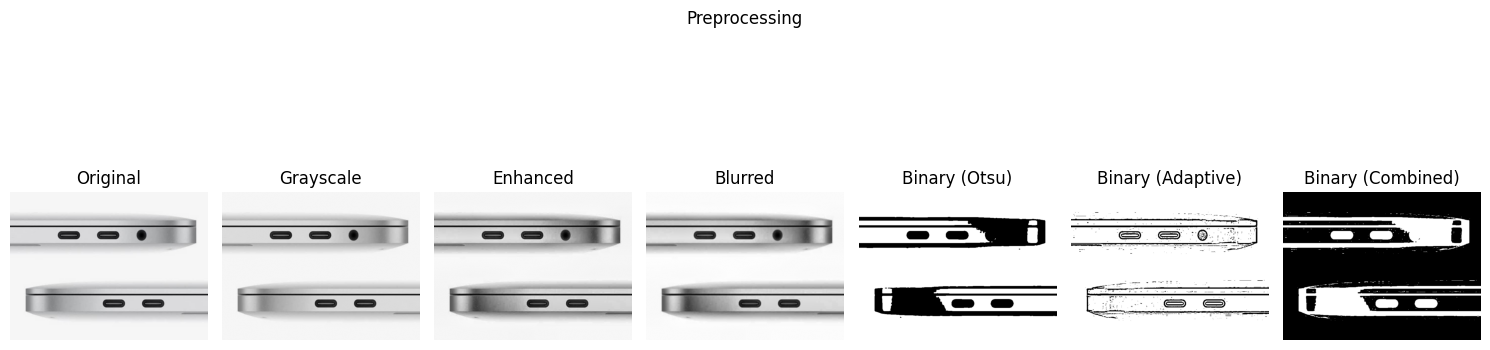

Extracted Features:
  - Aspect Ratio: 5.76
  - Area: 48791.0
  - Perimeter: 3747.85
  - Compactness: 0.04
  - Corner Count: 72
  - Pin Count: 6
  - Horizontal Lines: 6
  - Rectangularity: 0.49
  - Symmetry Score: 0.11357917
  - Central Line Detected: True
  - Central Line Length: 735.00
  - End Roundedness: 1.00


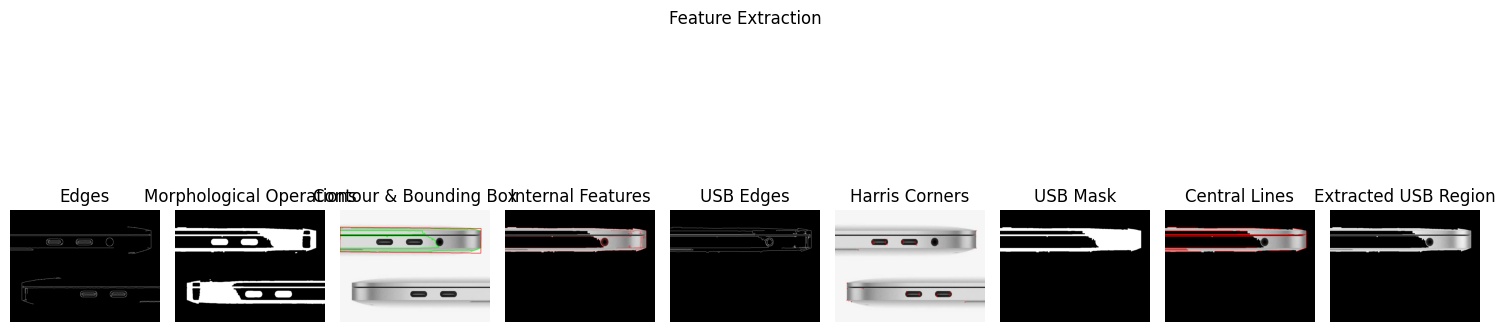

DEBUG - Feature values for classification:
  Aspect Ratio: 5.76
  Compactness: 0.04
  Corner Count: 72
  Pin Count: 6
  Horizontal Lines: 6
  Rectangularity: 0.49
  Symmetry Score: 0.11357917
  Area: 48791.0
  Central Line Detected: True
  Central Line Length: 735.00
  End Roundedness: 1.00
Confidence scores:
  USB-A: 0.40
    Reasons: Detected 6 horizontal lines (pins)
  USB-B: -0.20
  USB-C: 0.24
    Reasons: High symmetry (score: 0.1136), Strong central line (735.00 of width), Rounded ends detected (score: 1.00), Too many horizontal lines (6) for USB-C
  Micro-USB: -0.35
  Mini-USB: -0.10


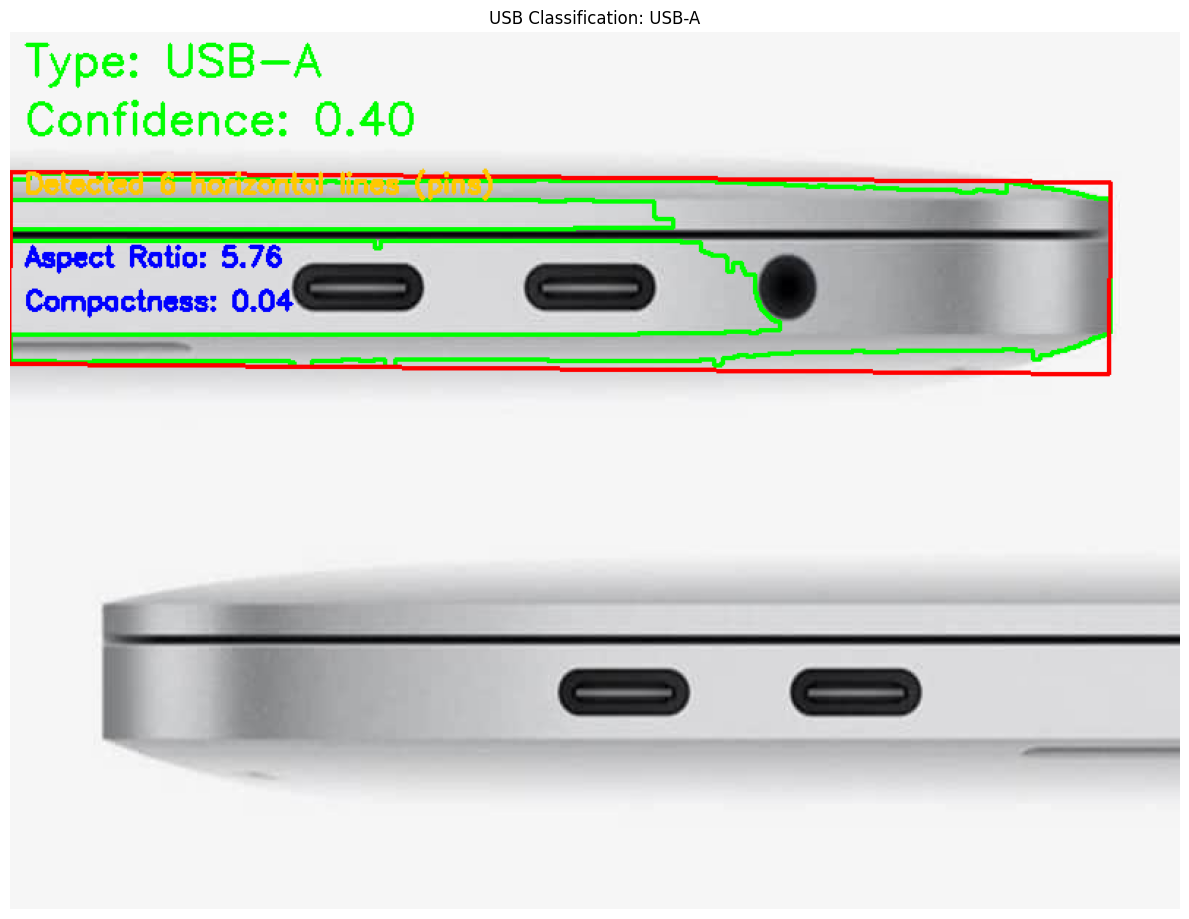

USB Type: USB-A
Confidence: 0.40
Reason: Detected 6 horizontal lines (pins)


In [44]:

try:
    usb_type, confidence, reason, result_img = process_image(image_path)
    print(f"USB Type: {usb_type.value}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Reason: {reason}")

    cv.imwrite('result.jpg', result_img)

except Exception as e:
    print(f"Error processing image: {str(e)}")